# 기본 설정

In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

# 기본 라이브러리
import os
import time
import shutil

# PyTorch 관련 라이브러리
import torch.utils.data as data
import torch.backends.cudnn as cudnn

# 이미지 변환 관련 라이브러리
from torchvision import transforms

# 데이터 로더 및 모델, 유틸리티 함수 불러오기
from data_loader import get_segmentation_dataset  # 데이터셋 불러오는 함수
from utils.loss import MixSoftmaxCrossEntropyLoss, MixSoftmaxCrossEntropyOHEMLoss  # 손실 함수
from utils.lr_scheduler import LRScheduler  # 학습률 스케줄러
from utils.metric import SegmentationMetric  # 평가 지표

In [2]:
import sys

# Python 모듈 경로에 'models' 폴더 추가
models_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/models"

if models_path not in sys.path:
    sys.path.append(models_path)  # models 폴더 추가
    
# sys.path 확인 (제대로 추가되었는지)
print("Python 경로 목록:")
print("\n".join(sys.path))

train_img_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/train"
dataset_root = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets"

Python 경로 목록:
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python39.zip
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/lib-dynload

/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages/IPython/extensions
/home/segmentsafestep/.ipython
/home/segmentsafestep/Fast-SCNN-pytorch-master/models


In [3]:
from modules import conv3x3, conv1x1, DWConvBNAct, PWConvBNAct, ConvBNAct, Activation, SegHead
from model_registry import register_model, aux_models

In [4]:
import torch

# GPU가 가능하면 사용하고, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("현재 사용 중인 디바이스:", device)
if torch.cuda.is_available():
    print("사용 중인 GPU:", torch.cuda.get_device_name(0))

현재 사용 중인 디바이스: cuda
사용 중인 GPU: NVIDIA L4


# 모델 설정

In [5]:
# BiSeNetV2 모델 정의
@register_model(aux_models)  # 모델을 등록하는 Decorator (사용자 정의 모델 등록을 위한 코드)
class BiSeNetv2(nn.Module):
    def __init__(self, num_class=1, n_channel=3, act_type='relu', use_aux=True):
        super().__init__()
        self.use_aux = use_aux  # 보조 분류(head) 사용 여부 설정 (True일 경우 보조 출력 사용)

        # 상세한 특징을 추출하는 Branch
        self.detail_branch = DetailBranch(n_channel, 128, act_type)

        # 의미론적 특징(Semantic Feature)을 추출하는 Branch
        self.semantic_branch = SemanticBranch(n_channel, 128, num_class, act_type, use_aux)

        # 두 개의 Branch에서 나온 특징을 합치는 Layer
        self.bga_layer = BilateralGuidedAggregationLayer(128, 128, act_type)

        # 최종 Segmentation 결과를 출력하는 Segmentation Head
        self.seg_head = SegHead(128, num_class, act_type)

    def forward(self, x, is_training=False): # 옵실러리 쓸거면 true
        size = x.size()[2:]  # 원본 입력 크기 저장 (업샘플링에 사용)
        x_d = self.detail_branch(x)  # Detail Branch 실행 (미세한 특징 추출)

        # 보조 분류 사용 여부에 따라 처리 방식 결정
        if self.use_aux:
            x_s, aux2, aux3, aux4, aux5 = self.semantic_branch(x)  # Semantic Branch 실행
        else:
            x_s = self.semantic_branch(x)

        x = self.bga_layer(x_d, x_s)  # 두 개의 Branch 출력 합성
        x = self.seg_head(x)  # 최종 Segmentation 결과 출력
        x = F.interpolate(x, size, mode='bilinear', align_corners=True)  # 원본 크기로 업샘플링

        # 보조 분류 사용 여부에 따라 추가 보조 출력 반환
        if self.use_aux and is_training:
            return x, (aux2, aux3, aux4, aux5)
        else:
            return x
        
# Detail Branch: 고해상도 특징을 유지하면서 세부 정보를 추출
class DetailBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__(
            ConvBNAct(in_channels, 64, 3, 2, act_type=act_type),  # 입력 채널 → 64 채널 변환, 다운샘플링
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv 연산 (필터 유지)
            ConvBNAct(64, 64, 3, 2, act_type=act_type),  # 다운샘플링
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv 연산
            ConvBNAct(64, 128, 3, 1, act_type=act_type),  # 채널 확장
            ConvBNAct(128, 128, 3, 2, act_type=act_type),  # 다운샘플링
            ConvBNAct(128, 128, 3, 1, act_type=act_type),  # Conv 연산
            ConvBNAct(128, out_channels, 3, 1, act_type=act_type)  # 최종 출력
        )
        
# Semantic Branch: 저해상도 특징을 추출하면서 의미론적 정보를 학습
class SemanticBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_class, act_type='relu', use_aux=False):
        super().__init__()
        self.use_aux = use_aux  # 보조 출력을 사용할지 여부

        # 첫 번째 단계: 초기 Feature 추출
        self.stage1to2 = StemBlock(in_channels, 16, act_type)

        # 두 번째 단계: 저해상도 특징 추출
        self.stage3 = nn.Sequential(
            GatherExpansionLayer(16, 32, 2, act_type),  # 다운샘플링 (16 → 32 채널)
            GatherExpansionLayer(32, 32, 1, act_type),  # Conv 연산
        )

        self.stage4 = nn.Sequential(
            GatherExpansionLayer(32, 64, 2, act_type),  # 다운샘플링 (32 → 64 채널)
            GatherExpansionLayer(64, 64, 1, act_type),  # Conv 연산
        )

        self.stage5_1to4 = nn.Sequential(
            GatherExpansionLayer(64, 128, 2, act_type),  # 다운샘플링 (64 → 128 채널)
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
        )

        self.stage5_5 = ContextEmbeddingBlock(128, out_channels, act_type)  # 글로벌 컨텍스트 학습

        # 보조 분류기 정의 (auxiliary segmentation heads)
        if self.use_aux:
            self.seg_head2 = SegHead(16, num_class, act_type)
            self.seg_head3 = SegHead(32, num_class, act_type)
            self.seg_head4 = SegHead(64, num_class, act_type)
            self.seg_head5 = SegHead(128, num_class, act_type)

    def forward(self, x):
        x = self.stage1to2(x)
        if self.use_aux:
            aux2 = self.seg_head2(x)

        x = self.stage3(x)
        if self.use_aux:
            aux3 = self.seg_head3(x)

        x = self.stage4(x)
        if self.use_aux:
            aux4 = self.seg_head4(x)

        x = self.stage5_1to4(x)
        if self.use_aux:
            aux5 = self.seg_head5(x)

        x = self.stage5_5(x)  # 최종 의미론적 정보 추출

        if self.use_aux:
            return x, aux2, aux3, aux4, aux5
        else:
            return x
        
class StemBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.conv_init = ConvBNAct(in_channels, out_channels, 3, 2, act_type=act_type)
        self.left_branch = nn.Sequential(
                            ConvBNAct(out_channels, out_channels//2, 1, act_type=act_type),
                            ConvBNAct(out_channels//2, out_channels, 3, 2, act_type=act_type)
                    )
        self.right_branch = nn.MaxPool2d(3, 2, 1)
        self.conv_last = ConvBNAct(out_channels*2, out_channels, 3, 1, act_type=act_type)

    def forward(self, x):
        x = self.conv_init(x)
        x_left = self.left_branch(x)
        x_right = self.right_branch(x)
        x = torch.cat([x_left, x_right], dim=1)
        x = self.conv_last(x)

        return x
    
class GatherExpansionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride, act_type='relu', expand_ratio=6,):
        super().__init__()
        self.stride = stride
        hid_channels = int(round(in_channels * expand_ratio))

        layers = [ConvBNAct(in_channels, in_channels, 3, act_type=act_type)]

        if stride == 2:
            layers.extend([
                            DWConvBNAct(in_channels, hid_channels, 3, 2, act_type='none'),
                            DWConvBNAct(hid_channels, hid_channels, 3, 1, act_type='none')
                        ])
            self.right_branch = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type='none'),
                                    PWConvBNAct(in_channels, out_channels, act_type='none')
                            )
        else:
            layers.append(DWConvBNAct(in_channels, hid_channels, 3, 1, act_type='none'))

        layers.append(PWConvBNAct(hid_channels, out_channels, act_type='none'))
        self.left_branch = nn.Sequential(*layers)
        self.act = Activation(act_type)

    def forward(self, x):
        res = self.left_branch(x)

        if self.stride == 2:
            res = self.right_branch(x) + res
        else:
            res = x + res

        return self.act(res)
    
class ContextEmbeddingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.pool = nn.Sequential(
                            nn.AdaptiveAvgPool2d(1),
                            nn.BatchNorm2d(in_channels)
                    )
        self.conv_mid = ConvBNAct(in_channels, in_channels, 1, act_type=act_type)
        self.conv_last = conv3x3(in_channels, out_channels)

    def forward(self, x):
        res = self.pool(x)
        res = self.conv_mid(res)
        x = res + x
        x = self.conv_last(x)

        return x
    
class BilateralGuidedAggregationLayer(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.detail_high = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels)
                        )
        self.detail_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type=act_type),
                                    nn.AvgPool2d(3, 2, 1)
                        )
        self.semantic_high = nn.Sequential(
                                    ConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True),
                                    nn.Sigmoid()
                            )
        self.semantic_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels),
                                    nn.Sigmoid()
                            )
        self.conv_last = ConvBNAct(in_channels, out_channels, 3, act_type=act_type)

    def forward(self, x_d, x_s):
        x_d_high = self.detail_high(x_d)
        x_d_low = self.detail_low(x_d)

        x_s_high = self.semantic_high(x_s)
        x_s_low = self.semantic_low(x_s)
        x_high = x_d_high * x_s_high
        x_low = x_d_low * x_s_low

        size = x_high.size()[2:]
        x_low = F.interpolate(x_low, size, mode='bilinear', align_corners=True)
        res = x_high + x_low
        res = self.conv_last(res)

        return res

In [6]:
# 클래스 2개로 만드는 코드
# CustomDataset: 기존 데이터셋을 road(0) vs none_road(1)로 변환하는 역할
class CustomDataset(data.Dataset):
    def __init__(self, original_dataset, road_class_id):
        self.original_dataset = original_dataset  # 원본 데이터셋
        self.road_class_id = road_class_id  # road 클래스 ID
        self.num_class = 2  # 클래스 개수를 2개(road, none_road)로 설정

    def __len__(self):
        return len(self.original_dataset)  # 원본 데이터셋 크기 반환

    def __getitem__(self, idx):
        image, target = self.original_dataset[idx]  # 원본 이미지 및 라벨 가져오기

        # road(0), 나머지는 none_road(1)로 변환
        target = torch.where(target == self.road_class_id, torch.tensor(0, dtype=torch.long), torch.tensor(1, dtype=torch.long))

        return image, target  # 변환된 이미지와 라벨 반환

In [7]:
# 클래스 2개
model = BiSeNetv2(num_class=2)

In [8]:
# 체크포인트 경로 설정
chk_pnt_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth"

# 기존 BiSeNetV2 모델 가중치 로드
chk_pnt_map = torch.load(chk_pnt_path, map_location="cpu")

# state_dict 여부 확인 후 로드
if "state_dict" in chk_pnt_map:
    pretrained_weights = chk_pnt_map["state_dict"]
else:
    pretrained_weights = chk_pnt_map

# 새로운 클래스 개수 정의
num_classes = 2  # road vs none-road
model = BiSeNetv2(num_class=num_classes)

# 기존 모델의 backbone 가중치만 가져오기 (seg_head, seg_head2~5 제외)
pretrained_weights = {
    k: v for k, v in pretrained_weights.items()
    if not k.startswith("seg_head") and not k.startswith("semantic_branch.seg_head")
}
model.load_state_dict(pretrained_weights, strict=False)  # Head 제외하고 로드

print("Backbone 가중치 로드 완료 (Head 부분 제외됨)")

# Head 부분을 학습 가능하게 설정 & 가중치 초기화
for param in model.parameters():
    param.requires_grad = False  # 기본적으로 모든 가중치 동결

def initialize_weights(layer):
    """Conv2D와 Linear에 대해서 Xavier 초기화 적용"""
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

# `seg_head` 가중치 초기화 및 학습 가능 설정
for param in model.seg_head.parameters():
    param.requires_grad = True  # 학습 가능하도록 설정
model.seg_head.apply(initialize_weights)  # Head 가중치 초기화

# 보조 분류기(auxiliary head)도 초기화 및 학습 가능하도록 설정
if model.use_aux:
    for head in [model.semantic_branch.seg_head2,
                 model.semantic_branch.seg_head3,
                 model.semantic_branch.seg_head4,
                 model.semantic_branch.seg_head5]:
        for param in head.parameters():
            param.requires_grad = True  # 학습 가능하도록 설정
        head.apply(initialize_weights)  # 보조 분류기 가중치 초기화

print("Head 및 보조 분류기 가중치 초기화 완료. 학습 가능하도록 설정됨.")

# GPU 사용 가능하면 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Backbone 가중치 로드 완료 (Head 부분 제외됨)
Head 및 보조 분류기 가중치 초기화 완료. 학습 가능하도록 설정됨.


BiSeNetv2(
  (detail_branch): DetailBranch(
    (0): ConvBNAct(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (1): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (2): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (3): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

---

# 학습

In [9]:
# 모델 및 학습 관련 하이퍼파라미터 설정
args = {
    "model": "BiSeNetv2",  # 사용할 모델 이름
    "dataset": "citys",  # 학습할 데이터셋 (예: Cityscapes)
    "base_size": 1024,  # 입력 이미지 기본 크기
    "crop_size": 768,  # 학습 시 사용할 크롭 크기
    "train_split": "train",  # 학습 데이터셋의 분할 방식

    # 학습 하이퍼파라미터
    "aux": False,  # 보조 손실 사용 여부
    "aux_weight": 0.4,  # 보조 손실 가중치
    "epochs": 151,  # 학습 에폭 수
    "start_epoch": 0,  # 학습 시작 에폭
    "batch_size": 2,  # 배치 크기
    "lr": 1e-2,  # 학습률
    "momentum": 0.9,  # 모멘텀
    "weight_decay": 1e-4,  # 가중치 감쇠 (L2 정규화)

    # 체크포인트 저장 위치
    "resume": True,  # 기존 모델 체크포인트 (사용하지 않음)
    "save_folder": "./weights",  # 모델 가중치 저장 경로

    # 평가 및 검증 설정
    "eval": True,  # 평가 모드 여부
    "no_val": False,  # 검증 생략 여부
}

# GPU 사용 여부 설정
print(device := torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
cudnn.benchmark = True  # GPU 연산 최적화
args["device"] = device  # 학습에 사용할 디바이스 저장

cuda:0


In [10]:
# 클래스 19개
# 이미지 전처리 변환 설정
input_transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize([0.3257, 0.3690, 0.3223], [0.2112, 0.2148, 0.2115]),  # 이미지 정규화
])

# 데이터셋 로드 (학습 및 검증)
data_kwargs = {"transform": input_transform, "base_size": args["base_size"], "crop_size": args["crop_size"]}
train_dataset = get_segmentation_dataset(args["dataset"], split=args["train_split"], mode="train", root=dataset_root, **data_kwargs)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="val", root=dataset_root, **data_kwargs)

# DataLoader 생성 (데이터 배치 단위로 로딩)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=args["batch_size"], shuffle=True, num_workers=6, # 이거 수정해봐
                               drop_last=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

# 모델을 GPU 또는 CPU로 이동
dev_mod = model.to(args["device"])

Found 2975 images in /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/train
Found 500 images in /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/val


In [11]:
# Cityscapes 데이터셋의 클래스 목록 (19개 클래스)
CITYSCAPES_CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car",
    "truck", "bus", "train", "motorcycle", "bicycle"
]

# road 클래스 ID 찾기
road_class_id = CITYSCAPES_CLASSES.index("road")  # road가 몇 번째 클래스인지 확인
print(f"road 클래스 ID: {road_class_id}")

road 클래스 ID: 0


In [20]:
# 클래스 2개 도로 and 도로 아님
# 이미지 전처리 변환 설정
input_transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize([0.3257, 0.3690, 0.3223], [0.2112, 0.2148, 0.2115]),  # 이미지 정규화
])

# road 클래스 ID 찾기
road_class_id = CITYSCAPES_CLASSES.index("road")  # road가 몇 번째 클래스인지 확인

# 기존 데이터셋 로드
train_dataset = get_segmentation_dataset(args["dataset"], split="train", mode="train", root=dataset_root, transform=input_transform)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="val", root=dataset_root, transform=input_transform)

# road vs none_road 변환 적용
train_dataset = CustomDataset(train_dataset, road_class_id)
val_dataset = CustomDataset(val_dataset, road_class_id)

# 데이터 로더 생성
train_loader = data.DataLoader(dataset=train_dataset, batch_size=args["batch_size"], shuffle=True, num_workers=6 # 이거 수정해봐
                               , drop_last=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

# 모델을 GPU 또는 CPU로 이동
dev_mod = model.to(args["device"])

Found 2975 images in /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/train
Found 500 images in /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/val


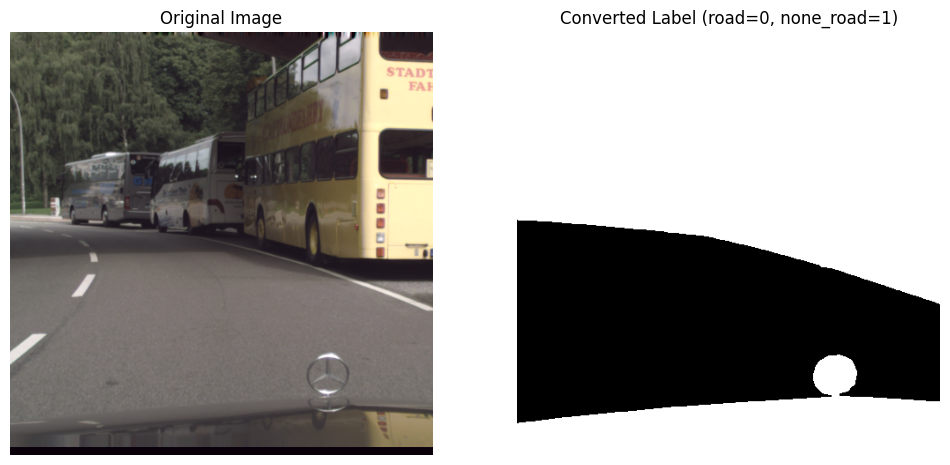

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 샘플 데이터 가져오기
image, target = train_dataset[0]  # 첫 번째 샘플 데이터

# 텐서를 NumPy 배열로 변환 (CPU로 이동 후 변환)
image_np = image.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C] 변환
image_np = (image_np * 0.2148) + 0.3690  # 정규화 해제 (평균 + 표준편차 곱하기)
image_np = np.clip(image_np, 0, 1)  # 값 범위 조정

target_np = target.cpu().numpy()  # 라벨 데이터 변환

# 원본 이미지와 변환된 라벨을 나란히 출력
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지 표시
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# 변환된 라벨 표시
axes[1].imshow(target_np, cmap="gray")  # 0(검은색), 1(흰색)
axes[1].set_title("Converted Label (road=0, none_road=1)")
axes[1].axis("off")

plt.show()

# 체크포인트

In [23]:
# 파라미터 개수, 레이어 확인
tot_num_param = 0
for layer_name, params in model.named_parameters():
    print(layer_name,'---', params.shape)
    n_p = 1
    for p in params.shape:
        n_p *= p
    tot_num_param += n_p

print("tot_num_param: ", tot_num_param)

detail_branch.0.0.weight --- torch.Size([64, 3, 3, 3])
detail_branch.0.1.weight --- torch.Size([64])
detail_branch.0.1.bias --- torch.Size([64])
detail_branch.1.0.weight --- torch.Size([64, 64, 3, 3])
detail_branch.1.1.weight --- torch.Size([64])
detail_branch.1.1.bias --- torch.Size([64])
detail_branch.2.0.weight --- torch.Size([64, 64, 3, 3])
detail_branch.2.1.weight --- torch.Size([64])
detail_branch.2.1.bias --- torch.Size([64])
detail_branch.3.0.weight --- torch.Size([64, 64, 3, 3])
detail_branch.3.1.weight --- torch.Size([64])
detail_branch.3.1.bias --- torch.Size([64])
detail_branch.4.0.weight --- torch.Size([128, 64, 3, 3])
detail_branch.4.1.weight --- torch.Size([128])
detail_branch.4.1.bias --- torch.Size([128])
detail_branch.5.0.weight --- torch.Size([128, 128, 3, 3])
detail_branch.5.1.weight --- torch.Size([128])
detail_branch.5.1.bias --- torch.Size([128])
detail_branch.6.0.weight --- torch.Size([128, 128, 3, 3])
detail_branch.6.1.weight --- torch.Size([128])
detail_branch

In [24]:
# head 부분만 학습 가능하게 설정
for name, param in model.named_parameters():
    if "seg_head" in name or "seg_head2" in name or "seg_head3" in name or "seg_head4" in name or "seg_head5" in name:
        param.requires_grad = True  # head 부분 학습
    else:
        param.requires_grad = False  # backbone 부분 동결

# 옵티마이저를 새로 초기화 (학습 가능한 파라미터만 업데이트)
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=args["lr"],
    momentum=args["momentum"],
    weight_decay=args["weight_decay"]
)

In [25]:
# 손실 함수 설정 (OHEM Loss 사용)
# 클래스 3개 이상 손실함수
# criterion = MixSoftmaxCrossEntropyLoss(aux=args["aux"], aux_weight=args["aux_weight"], ignore_label=-1).to(args["device"])

# 클래스 2개 손실함수
criterion = torch.nn.CrossEntropyLoss().to(args["device"])

# 학습률 스케줄러 설정 (poly decay 사용)
lr_scheduler = LRScheduler(mode="poly", base_lr=args["lr"], nepochs=args["epochs"],
                           iters_per_epoch=len(train_loader), power=0.9)

# 평가 지표 (mIoU 등)
metric = SegmentationMetric(train_dataset.num_class)

# 최고 성능 저장을 위한 변수
best_pred = 0.0

In [31]:
# train() 함수 수정 (히스토리 저장 포함)
def train():
    global best_pred
    cur_iters = 0
    start_time = time.time()

    os.makedirs(args["save_folder"], exist_ok=True)

    # 히스토리 저장용 딕셔너리
    history = {"epoch": [], "loss": [], "lr": [], "val_mIoU": [],}

    if args["resume"]:
        if os.path.exists(chk_pnt_path):
            print(f"이전 학습 가중치 불러오는 중: {chk_pnt_path}")
            checkpoint = torch.load(chk_pnt_path, map_location=args["device"])
            checkpoint_state = {
                k: v for k, v in checkpoint["state_dict"].items()
                if not k.startswith("seg_head") and not k.startswith("semantic_branch.seg_head")
            }
            model.load_state_dict(checkpoint_state, strict=False)
            start_epoch = checkpoint.get("epoch", -1) + 1
            print(f"학습을 {start_epoch}번째 에포크부터 이어서 진행합니다.")
        else:
            print("지정된 체크포인트 파일을 찾을 수 없습니다. 처음부터 학습을 시작합니다.")
            start_epoch = args["start_epoch"]
    else:
        start_epoch = args["start_epoch"]

    for epoch in range(start_epoch, args["epochs"]):
        model.train()
        start_time = time.time()

        epoch_loss = 0.0
        for i, (images, targets) in enumerate(train_loader):
            cur_lr = lr_scheduler(cur_iters)
            for param_group in optimizer.param_groups:
                param_group["lr"] = cur_lr

            images, targets = images.to(args["device"]), targets.to(args["device"])
            targets = targets.long()

            outputs = model(images)
            outputs = F.interpolate(outputs, size=targets.shape[-2:], mode="bilinear", align_corners=True)

            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            cur_iters += 1
            if cur_iters % 100 == 0:
                print(f"Epoch [{epoch}/{args['epochs']}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / len(train_loader)
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch} 완료! 소요 시간: {epoch_time:.2f} 초")

        history["epoch"].append(epoch)
        history["loss"].append(avg_loss)
        history["lr"].append(cur_lr)

        if not args["no_val"]:
            val_mIoU = validation(epoch)
            history["val_mIoU"].append(val_mIoU)

        if epoch % 10 == 0:
            save_path = os.path.join(args["save_folder"], f"model_finetuning_test_{epoch}.pth")
            torch.save({"epoch": epoch, "state_dict": model.state_dict()}, save_path)
            print(f"모델 가중치 저장됨: {save_path}")

    # 학습 히스토리 저장
    import json
    with open(os.path.join(args["save_folder"], "train_history.json"), "w") as f:
        json.dump(history, f)
    print("학습 히스토리 저장 완료!")

In [32]:
def validation(epoch):
    global best_pred
    model.eval()
    metric.reset()

    for i, (image, target) in enumerate(val_loader):
        image = image.to(args["device"])
        with torch.no_grad():
            outputs = (model(image),)

        pred = torch.argmax(outputs[0], 1).cpu().data.numpy()
        metric.update(pred, target.numpy())

    pixAcc, mIoU = metric.get()
    print(f"Epoch {epoch}, Validation PixAcc: {pixAcc:.3f}, mIoU: {mIoU:.3f}")

    new_pred = (pixAcc + mIoU) / 2
    if new_pred > best_pred:
        best_pred = new_pred

    return mIoU  # 👈 train()에서 저장하기 위해 mIoU 반환

In [33]:
# 클래스 2개
train()

이전 학습 가중치 불러오는 중: /home/segmentsafestep/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

Epoch [11/50], Step [62/1487], Loss: 0.0241
Epoch [11/50], Step [72/1487], Loss: 0.1082
Epoch [11/50], Step [82/1487], Loss: 0.0628
Epoch [11/50], Step [92/1487], Loss: 0.0629
Epoch [11/50], Step [102/1487], Loss: 0.0769
Epoch [11/50], Step [112/1487], Loss: 0.2885
Epoch [11/50], Step [122/1487], Loss: 0.1875
Epoch [11/50], Step [132/1487], Loss: 0.1980
Epoch [11/50], Step [142/1487], Loss: 0.0663
Epoch [11/50], Step [152/1487], Loss: 0.0574
Epoch [11/50], Step [162/1487], Loss: 0.1317
Epoch [11/50], Step [172/1487], Loss: 0.0222
Epoch [11/50], Step [182/1487], Loss: 0.0585
Epoch [11/50], Step [192/1487], Loss: 0.1579
Epoch [11/50], Step [202/1487], Loss: 0.0911
Epoch [11/50], Step [212/1487], Loss: 0.0363
Epoch [11/50], Step [222/1487], Loss: 0.0565
Epoch [11/50], Step [232/1487], Loss: 0.0685
Epoch [11/50], Step [242/1487], Loss: 0.1085
Epoch [11/50], Step [252/1487], Loss: 0.1185
Epoch [11/50], Step [262/1487], Loss: 0.3023
Epoch [11/50], Step [272/1487], Loss: 0.0682
Epoch [11/50],

Epoch [12/50], Step [375/1487], Loss: 0.0499
Epoch [12/50], Step [385/1487], Loss: 0.7459
Epoch [12/50], Step [395/1487], Loss: 0.0824
Epoch [12/50], Step [405/1487], Loss: 0.1173
Epoch [12/50], Step [415/1487], Loss: 0.0544
Epoch [12/50], Step [425/1487], Loss: 0.0827
Epoch [12/50], Step [435/1487], Loss: 0.5187
Epoch [12/50], Step [445/1487], Loss: 0.0645
Epoch [12/50], Step [455/1487], Loss: 0.0719
Epoch [12/50], Step [465/1487], Loss: 0.0579
Epoch [12/50], Step [475/1487], Loss: 0.0875
Epoch [12/50], Step [485/1487], Loss: 0.3611
Epoch [12/50], Step [495/1487], Loss: 0.0530
Epoch [12/50], Step [505/1487], Loss: 0.0720
Epoch [12/50], Step [515/1487], Loss: 0.5695
Epoch [12/50], Step [525/1487], Loss: 0.1486
Epoch [12/50], Step [535/1487], Loss: 0.0653
Epoch [12/50], Step [545/1487], Loss: 0.1140
Epoch [12/50], Step [555/1487], Loss: 0.0481
Epoch [12/50], Step [565/1487], Loss: 0.0617
Epoch [12/50], Step [575/1487], Loss: 0.0589
Epoch [12/50], Step [585/1487], Loss: 0.2922
Epoch [12/

Epoch [13/50], Step [688/1487], Loss: 0.0887
Epoch [13/50], Step [698/1487], Loss: 0.0645
Epoch [13/50], Step [708/1487], Loss: 0.1231
Epoch [13/50], Step [718/1487], Loss: 0.1312
Epoch [13/50], Step [728/1487], Loss: 0.0577
Epoch [13/50], Step [738/1487], Loss: 0.0597
Epoch [13/50], Step [748/1487], Loss: 0.0469
Epoch [13/50], Step [758/1487], Loss: 0.0687
Epoch [13/50], Step [768/1487], Loss: 0.0936
Epoch [13/50], Step [778/1487], Loss: 0.3766
Epoch [13/50], Step [788/1487], Loss: 0.0522
Epoch [13/50], Step [798/1487], Loss: 0.2486
Epoch [13/50], Step [808/1487], Loss: 0.5576
Epoch [13/50], Step [818/1487], Loss: 0.0904
Epoch [13/50], Step [828/1487], Loss: 0.0661
Epoch [13/50], Step [838/1487], Loss: 0.1207
Epoch [13/50], Step [848/1487], Loss: 0.0706
Epoch [13/50], Step [858/1487], Loss: 0.0743
Epoch [13/50], Step [868/1487], Loss: 0.3592
Epoch [13/50], Step [878/1487], Loss: 0.1175
Epoch [13/50], Step [888/1487], Loss: 0.3043
Epoch [13/50], Step [898/1487], Loss: 0.0474
Epoch [13/

Epoch [14/50], Step [1001/1487], Loss: 0.3076
Epoch [14/50], Step [1011/1487], Loss: 0.0886
Epoch [14/50], Step [1021/1487], Loss: 0.0521
Epoch [14/50], Step [1031/1487], Loss: 0.0546
Epoch [14/50], Step [1041/1487], Loss: 0.3535
Epoch [14/50], Step [1051/1487], Loss: 0.0841
Epoch [14/50], Step [1061/1487], Loss: 0.0686
Epoch [14/50], Step [1071/1487], Loss: 0.0669
Epoch [14/50], Step [1081/1487], Loss: 0.0468
Epoch [14/50], Step [1091/1487], Loss: 0.1107
Epoch [14/50], Step [1101/1487], Loss: 0.0633
Epoch [14/50], Step [1111/1487], Loss: 0.0745
Epoch [14/50], Step [1121/1487], Loss: 0.1097
Epoch [14/50], Step [1131/1487], Loss: 0.0407
Epoch [14/50], Step [1141/1487], Loss: 0.0749
Epoch [14/50], Step [1151/1487], Loss: 0.0717
Epoch [14/50], Step [1161/1487], Loss: 0.6405
Epoch [14/50], Step [1171/1487], Loss: 0.0715
Epoch [14/50], Step [1181/1487], Loss: 0.0702
Epoch [14/50], Step [1191/1487], Loss: 0.1427
Epoch [14/50], Step [1201/1487], Loss: 0.0566
Epoch [14/50], Step [1211/1487], L

Epoch [15/50], Step [1304/1487], Loss: 0.2419
Epoch [15/50], Step [1314/1487], Loss: 0.1215
Epoch [15/50], Step [1324/1487], Loss: 0.0785
Epoch [15/50], Step [1334/1487], Loss: 0.1164
Epoch [15/50], Step [1344/1487], Loss: 0.0954
Epoch [15/50], Step [1354/1487], Loss: 0.1234
Epoch [15/50], Step [1364/1487], Loss: 0.0726
Epoch [15/50], Step [1374/1487], Loss: 0.0814
Epoch [15/50], Step [1384/1487], Loss: 0.0858
Epoch [15/50], Step [1394/1487], Loss: 0.1110
Epoch [15/50], Step [1404/1487], Loss: 0.0697
Epoch [15/50], Step [1414/1487], Loss: 0.0958
Epoch [15/50], Step [1424/1487], Loss: 0.0569
Epoch [15/50], Step [1434/1487], Loss: 0.0774
Epoch [15/50], Step [1444/1487], Loss: 0.0729
Epoch [15/50], Step [1454/1487], Loss: 0.0705
Epoch [15/50], Step [1464/1487], Loss: 0.0477
Epoch [15/50], Step [1474/1487], Loss: 0.1141
Epoch [15/50], Step [1484/1487], Loss: 0.0717
Epoch 15 완료! 소요 시간: 731.45 초
모델 가중치 저장됨: ./weights/model_finetuning_15.pth
Epoch 15, Validation PixAcc: 0.961, mIoU: 0.921
Epo

Epoch [17/50], Step [100/1487], Loss: 0.0965
Epoch [17/50], Step [110/1487], Loss: 0.0672
Epoch [17/50], Step [120/1487], Loss: 0.0632
Epoch [17/50], Step [130/1487], Loss: 0.1790
Epoch [17/50], Step [140/1487], Loss: 0.0825
Epoch [17/50], Step [150/1487], Loss: 0.1255
Epoch [17/50], Step [160/1487], Loss: 0.1504
Epoch [17/50], Step [170/1487], Loss: 0.0393
Epoch [17/50], Step [180/1487], Loss: 0.0820
Epoch [17/50], Step [190/1487], Loss: 0.0794
Epoch [17/50], Step [200/1487], Loss: 0.0784
Epoch [17/50], Step [210/1487], Loss: 0.0829
Epoch [17/50], Step [220/1487], Loss: 0.0899
Epoch [17/50], Step [230/1487], Loss: 0.8570
Epoch [17/50], Step [240/1487], Loss: 0.0691
Epoch [17/50], Step [250/1487], Loss: 0.0559
Epoch [17/50], Step [260/1487], Loss: 0.0840
Epoch [17/50], Step [270/1487], Loss: 0.0390
Epoch [17/50], Step [280/1487], Loss: 0.0643
Epoch [17/50], Step [290/1487], Loss: 0.0620
Epoch [17/50], Step [300/1487], Loss: 0.0846
Epoch [17/50], Step [310/1487], Loss: 0.0940
Epoch [17/

Epoch [18/50], Step [413/1487], Loss: 0.0983
Epoch [18/50], Step [423/1487], Loss: 0.0585
Epoch [18/50], Step [433/1487], Loss: 0.0944
Epoch [18/50], Step [443/1487], Loss: 0.0784
Epoch [18/50], Step [453/1487], Loss: 0.2223
Epoch [18/50], Step [463/1487], Loss: 0.1300
Epoch [18/50], Step [473/1487], Loss: 0.1905
Epoch [18/50], Step [483/1487], Loss: 0.0612
Epoch [18/50], Step [493/1487], Loss: 0.0748
Epoch [18/50], Step [503/1487], Loss: 0.0816
Epoch [18/50], Step [513/1487], Loss: 0.1059
Epoch [18/50], Step [523/1487], Loss: 0.1027
Epoch [18/50], Step [533/1487], Loss: 0.0683
Epoch [18/50], Step [543/1487], Loss: 0.1052
Epoch [18/50], Step [553/1487], Loss: 0.1015
Epoch [18/50], Step [563/1487], Loss: 0.0673
Epoch [18/50], Step [573/1487], Loss: 0.0616
Epoch [18/50], Step [583/1487], Loss: 0.0522
Epoch [18/50], Step [593/1487], Loss: 0.0648
Epoch [18/50], Step [603/1487], Loss: 0.1271
Epoch [18/50], Step [613/1487], Loss: 0.1099
Epoch [18/50], Step [623/1487], Loss: 0.0777
Epoch [18/

Epoch [19/50], Step [726/1487], Loss: 0.0301
Epoch [19/50], Step [736/1487], Loss: 0.1327
Epoch [19/50], Step [746/1487], Loss: 0.3076
Epoch [19/50], Step [756/1487], Loss: 0.2087
Epoch [19/50], Step [766/1487], Loss: 0.0710
Epoch [19/50], Step [776/1487], Loss: 0.2220
Epoch [19/50], Step [786/1487], Loss: 0.6634
Epoch [19/50], Step [796/1487], Loss: 0.3151
Epoch [19/50], Step [806/1487], Loss: 0.0435
Epoch [19/50], Step [816/1487], Loss: 0.0807
Epoch [19/50], Step [826/1487], Loss: 0.1849
Epoch [19/50], Step [836/1487], Loss: 0.1576
Epoch [19/50], Step [846/1487], Loss: 0.0798
Epoch [19/50], Step [856/1487], Loss: 0.0867
Epoch [19/50], Step [866/1487], Loss: 0.1168
Epoch [19/50], Step [876/1487], Loss: 0.0407
Epoch [19/50], Step [886/1487], Loss: 0.0863
Epoch [19/50], Step [896/1487], Loss: 0.0938
Epoch [19/50], Step [906/1487], Loss: 0.0643
Epoch [19/50], Step [916/1487], Loss: 0.1202
Epoch [19/50], Step [926/1487], Loss: 0.1130
Epoch [19/50], Step [936/1487], Loss: 0.0615
Epoch [19/

Epoch [20/50], Step [1039/1487], Loss: 0.0976
Epoch [20/50], Step [1049/1487], Loss: 0.1282
Epoch [20/50], Step [1059/1487], Loss: 0.2186
Epoch [20/50], Step [1069/1487], Loss: 0.0693
Epoch [20/50], Step [1079/1487], Loss: 0.0481
Epoch [20/50], Step [1089/1487], Loss: 0.0559
Epoch [20/50], Step [1099/1487], Loss: 0.1143
Epoch [20/50], Step [1109/1487], Loss: 0.0412
Epoch [20/50], Step [1119/1487], Loss: 0.1169
Epoch [20/50], Step [1129/1487], Loss: 0.0680
Epoch [20/50], Step [1139/1487], Loss: 0.4812
Epoch [20/50], Step [1149/1487], Loss: 0.0772
Epoch [20/50], Step [1159/1487], Loss: 0.0561
Epoch [20/50], Step [1169/1487], Loss: 0.2492
Epoch [20/50], Step [1179/1487], Loss: 0.0522
Epoch [20/50], Step [1189/1487], Loss: 0.0408
Epoch [20/50], Step [1199/1487], Loss: 0.0616
Epoch [20/50], Step [1209/1487], Loss: 0.0498
Epoch [20/50], Step [1219/1487], Loss: 0.2014
Epoch [20/50], Step [1229/1487], Loss: 0.0756
Epoch [20/50], Step [1239/1487], Loss: 0.1326
Epoch [20/50], Step [1249/1487], L

Epoch [21/50], Step [1332/1487], Loss: 0.0584
Epoch [21/50], Step [1342/1487], Loss: 0.0861
Epoch [21/50], Step [1352/1487], Loss: 0.0721
Epoch [21/50], Step [1362/1487], Loss: 0.2387
Epoch [21/50], Step [1372/1487], Loss: 0.1936
Epoch [21/50], Step [1382/1487], Loss: 0.1303
Epoch [21/50], Step [1392/1487], Loss: 0.5580
Epoch [21/50], Step [1402/1487], Loss: 0.0724
Epoch [21/50], Step [1412/1487], Loss: 0.1783
Epoch [21/50], Step [1422/1487], Loss: 0.0623
Epoch [21/50], Step [1432/1487], Loss: 0.0402
Epoch [21/50], Step [1442/1487], Loss: 0.0503
Epoch [21/50], Step [1452/1487], Loss: 0.0448
Epoch [21/50], Step [1462/1487], Loss: 0.0225
Epoch [21/50], Step [1472/1487], Loss: 0.1882
Epoch [21/50], Step [1482/1487], Loss: 0.2216
Epoch 21 완료! 소요 시간: 713.80 초
Epoch 21, Validation PixAcc: 0.962, mIoU: 0.921
Epoch [22/50], Step [5/1487], Loss: 0.0979
Epoch [22/50], Step [15/1487], Loss: 0.0481
Epoch [22/50], Step [25/1487], Loss: 0.1162
Epoch [22/50], Step [35/1487], Loss: 0.0307
Epoch [22/50

Epoch [23/50], Step [138/1487], Loss: 0.0659
Epoch [23/50], Step [148/1487], Loss: 0.0485
Epoch [23/50], Step [158/1487], Loss: 0.3366
Epoch [23/50], Step [168/1487], Loss: 0.0409
Epoch [23/50], Step [178/1487], Loss: 0.0786
Epoch [23/50], Step [188/1487], Loss: 0.0701
Epoch [23/50], Step [198/1487], Loss: 0.0547
Epoch [23/50], Step [208/1487], Loss: 0.0437
Epoch [23/50], Step [218/1487], Loss: 0.0700
Epoch [23/50], Step [228/1487], Loss: 0.1934
Epoch [23/50], Step [238/1487], Loss: 0.1000
Epoch [23/50], Step [248/1487], Loss: 0.0897
Epoch [23/50], Step [258/1487], Loss: 0.0523
Epoch [23/50], Step [268/1487], Loss: 0.0362
Epoch [23/50], Step [278/1487], Loss: 0.0298
Epoch [23/50], Step [288/1487], Loss: 0.0784
Epoch [23/50], Step [298/1487], Loss: 0.0845
Epoch [23/50], Step [308/1487], Loss: 0.0809
Epoch [23/50], Step [318/1487], Loss: 0.0789
Epoch [23/50], Step [328/1487], Loss: 0.2641
Epoch [23/50], Step [338/1487], Loss: 0.0759
Epoch [23/50], Step [348/1487], Loss: 0.1553
Epoch [23/

Epoch [24/50], Step [451/1487], Loss: 0.1619
Epoch [24/50], Step [461/1487], Loss: 0.1217
Epoch [24/50], Step [471/1487], Loss: 0.0837
Epoch [24/50], Step [481/1487], Loss: 0.0275
Epoch [24/50], Step [491/1487], Loss: 0.0488
Epoch [24/50], Step [501/1487], Loss: 0.1537
Epoch [24/50], Step [511/1487], Loss: 0.0531
Epoch [24/50], Step [521/1487], Loss: 0.0447
Epoch [24/50], Step [531/1487], Loss: 0.0757
Epoch [24/50], Step [541/1487], Loss: 0.0577
Epoch [24/50], Step [551/1487], Loss: 0.1077
Epoch [24/50], Step [561/1487], Loss: 0.0482
Epoch [24/50], Step [571/1487], Loss: 0.1563
Epoch [24/50], Step [581/1487], Loss: 0.1201
Epoch [24/50], Step [591/1487], Loss: 0.0473
Epoch [24/50], Step [601/1487], Loss: 0.1123
Epoch [24/50], Step [611/1487], Loss: 0.0338
Epoch [24/50], Step [621/1487], Loss: 0.0600
Epoch [24/50], Step [631/1487], Loss: 0.0937
Epoch [24/50], Step [641/1487], Loss: 0.0901
Epoch [24/50], Step [651/1487], Loss: 0.1148
Epoch [24/50], Step [661/1487], Loss: 0.1172
Epoch [24/

Epoch [25/50], Step [764/1487], Loss: 0.0603
Epoch [25/50], Step [774/1487], Loss: 0.1254
Epoch [25/50], Step [784/1487], Loss: 0.0698
Epoch [25/50], Step [794/1487], Loss: 0.0502
Epoch [25/50], Step [804/1487], Loss: 0.0314
Epoch [25/50], Step [814/1487], Loss: 0.0921
Epoch [25/50], Step [824/1487], Loss: 0.0644
Epoch [25/50], Step [834/1487], Loss: 0.0510
Epoch [25/50], Step [844/1487], Loss: 0.1608
Epoch [25/50], Step [854/1487], Loss: 0.0906
Epoch [25/50], Step [864/1487], Loss: 0.0274
Epoch [25/50], Step [874/1487], Loss: 0.1741
Epoch [25/50], Step [884/1487], Loss: 0.1157
Epoch [25/50], Step [894/1487], Loss: 0.1026
Epoch [25/50], Step [904/1487], Loss: 0.0540
Epoch [25/50], Step [914/1487], Loss: 0.0754
Epoch [25/50], Step [924/1487], Loss: 0.0533
Epoch [25/50], Step [934/1487], Loss: 0.0645
Epoch [25/50], Step [944/1487], Loss: 0.1021
Epoch [25/50], Step [954/1487], Loss: 0.0509
Epoch [25/50], Step [964/1487], Loss: 0.0969
Epoch [25/50], Step [974/1487], Loss: 0.0595
Epoch [25/

Epoch [26/50], Step [1067/1487], Loss: 0.1375
Epoch [26/50], Step [1077/1487], Loss: 0.1276
Epoch [26/50], Step [1087/1487], Loss: 0.3110
Epoch [26/50], Step [1097/1487], Loss: 0.0456
Epoch [26/50], Step [1107/1487], Loss: 0.0462
Epoch [26/50], Step [1117/1487], Loss: 0.3901
Epoch [26/50], Step [1127/1487], Loss: 0.0670
Epoch [26/50], Step [1137/1487], Loss: 0.0463
Epoch [26/50], Step [1147/1487], Loss: 0.1946
Epoch [26/50], Step [1157/1487], Loss: 0.0978
Epoch [26/50], Step [1167/1487], Loss: 0.0456
Epoch [26/50], Step [1177/1487], Loss: 0.2853
Epoch [26/50], Step [1187/1487], Loss: 0.0749
Epoch [26/50], Step [1197/1487], Loss: 0.0933
Epoch [26/50], Step [1207/1487], Loss: 0.2107
Epoch [26/50], Step [1217/1487], Loss: 0.0659
Epoch [26/50], Step [1227/1487], Loss: 0.1051
Epoch [26/50], Step [1237/1487], Loss: 0.0727
Epoch [26/50], Step [1247/1487], Loss: 0.0533
Epoch [26/50], Step [1257/1487], Loss: 0.1003
Epoch [26/50], Step [1267/1487], Loss: 0.1374
Epoch [26/50], Step [1277/1487], L

Epoch [27/50], Step [1370/1487], Loss: 0.4987
Epoch [27/50], Step [1380/1487], Loss: 0.2197
Epoch [27/50], Step [1390/1487], Loss: 0.0361
Epoch [27/50], Step [1400/1487], Loss: 0.0852
Epoch [27/50], Step [1410/1487], Loss: 0.0902
Epoch [27/50], Step [1420/1487], Loss: 0.0617
Epoch [27/50], Step [1430/1487], Loss: 0.0544
Epoch [27/50], Step [1440/1487], Loss: 0.0677
Epoch [27/50], Step [1450/1487], Loss: 0.0348
Epoch [27/50], Step [1460/1487], Loss: 0.1254
Epoch [27/50], Step [1470/1487], Loss: 0.0549
Epoch [27/50], Step [1480/1487], Loss: 0.0728
Epoch 27 완료! 소요 시간: 720.75 초
Epoch 27, Validation PixAcc: 0.964, mIoU: 0.925
Epoch [28/50], Step [3/1487], Loss: 0.0384
Epoch [28/50], Step [13/1487], Loss: 0.1377
Epoch [28/50], Step [23/1487], Loss: 0.0591
Epoch [28/50], Step [33/1487], Loss: 0.0589
Epoch [28/50], Step [43/1487], Loss: 0.0293
Epoch [28/50], Step [53/1487], Loss: 0.4654
Epoch [28/50], Step [63/1487], Loss: 0.0766
Epoch [28/50], Step [73/1487], Loss: 0.1574
Epoch [28/50], Step 

Epoch [29/50], Step [176/1487], Loss: 0.3875
Epoch [29/50], Step [186/1487], Loss: 0.0985
Epoch [29/50], Step [196/1487], Loss: 0.0616
Epoch [29/50], Step [206/1487], Loss: 0.0545
Epoch [29/50], Step [216/1487], Loss: 0.0694
Epoch [29/50], Step [226/1487], Loss: 0.0442
Epoch [29/50], Step [236/1487], Loss: 0.1710
Epoch [29/50], Step [246/1487], Loss: 0.0315
Epoch [29/50], Step [256/1487], Loss: 0.0783
Epoch [29/50], Step [266/1487], Loss: 0.1583
Epoch [29/50], Step [276/1487], Loss: 0.1123
Epoch [29/50], Step [286/1487], Loss: 0.0514
Epoch [29/50], Step [296/1487], Loss: 0.2479
Epoch [29/50], Step [306/1487], Loss: 0.1063
Epoch [29/50], Step [316/1487], Loss: 0.2242
Epoch [29/50], Step [326/1487], Loss: 0.1246
Epoch [29/50], Step [336/1487], Loss: 0.0399
Epoch [29/50], Step [346/1487], Loss: 0.0425
Epoch [29/50], Step [356/1487], Loss: 0.1595
Epoch [29/50], Step [366/1487], Loss: 0.0457
Epoch [29/50], Step [376/1487], Loss: 0.2146
Epoch [29/50], Step [386/1487], Loss: 0.0982
Epoch [29/

Epoch [30/50], Step [489/1487], Loss: 0.0887
Epoch [30/50], Step [499/1487], Loss: 0.0567
Epoch [30/50], Step [509/1487], Loss: 0.0445
Epoch [30/50], Step [519/1487], Loss: 0.1839
Epoch [30/50], Step [529/1487], Loss: 0.0898
Epoch [30/50], Step [539/1487], Loss: 0.0491
Epoch [30/50], Step [549/1487], Loss: 0.0369
Epoch [30/50], Step [559/1487], Loss: 0.1462
Epoch [30/50], Step [569/1487], Loss: 0.0853
Epoch [30/50], Step [579/1487], Loss: 0.0530
Epoch [30/50], Step [589/1487], Loss: 0.0792
Epoch [30/50], Step [599/1487], Loss: 0.0566
Epoch [30/50], Step [609/1487], Loss: 0.6652
Epoch [30/50], Step [619/1487], Loss: 0.0734
Epoch [30/50], Step [629/1487], Loss: 0.1391
Epoch [30/50], Step [639/1487], Loss: 0.0333
Epoch [30/50], Step [649/1487], Loss: 0.0462
Epoch [30/50], Step [659/1487], Loss: 0.5848
Epoch [30/50], Step [669/1487], Loss: 0.0572
Epoch [30/50], Step [679/1487], Loss: 0.1412
Epoch [30/50], Step [689/1487], Loss: 0.0907
Epoch [30/50], Step [699/1487], Loss: 0.1090
Epoch [30/

Epoch [31/50], Step [792/1487], Loss: 0.0388
Epoch [31/50], Step [802/1487], Loss: 0.0782
Epoch [31/50], Step [812/1487], Loss: 0.0509
Epoch [31/50], Step [822/1487], Loss: 0.0362
Epoch [31/50], Step [832/1487], Loss: 0.0708
Epoch [31/50], Step [842/1487], Loss: 0.0907
Epoch [31/50], Step [852/1487], Loss: 0.0469
Epoch [31/50], Step [862/1487], Loss: 0.0777
Epoch [31/50], Step [872/1487], Loss: 0.0580
Epoch [31/50], Step [882/1487], Loss: 0.1326
Epoch [31/50], Step [892/1487], Loss: 0.0293
Epoch [31/50], Step [902/1487], Loss: 0.0487
Epoch [31/50], Step [912/1487], Loss: 0.0460
Epoch [31/50], Step [922/1487], Loss: 0.2074
Epoch [31/50], Step [932/1487], Loss: 0.0796
Epoch [31/50], Step [942/1487], Loss: 0.0981
Epoch [31/50], Step [952/1487], Loss: 0.0322
Epoch [31/50], Step [962/1487], Loss: 0.0604
Epoch [31/50], Step [972/1487], Loss: 0.0538
Epoch [31/50], Step [982/1487], Loss: 0.0295
Epoch [31/50], Step [992/1487], Loss: 0.2048
Epoch [31/50], Step [1002/1487], Loss: 0.4882
Epoch [31

Epoch [32/50], Step [1105/1487], Loss: 0.0986
Epoch [32/50], Step [1115/1487], Loss: 0.0859
Epoch [32/50], Step [1125/1487], Loss: 0.0676
Epoch [32/50], Step [1135/1487], Loss: 0.0703
Epoch [32/50], Step [1145/1487], Loss: 0.1137
Epoch [32/50], Step [1155/1487], Loss: 0.3913
Epoch [32/50], Step [1165/1487], Loss: 0.0689
Epoch [32/50], Step [1175/1487], Loss: 0.0665
Epoch [32/50], Step [1185/1487], Loss: 0.0741
Epoch [32/50], Step [1195/1487], Loss: 0.0317
Epoch [32/50], Step [1205/1487], Loss: 0.0310
Epoch [32/50], Step [1215/1487], Loss: 0.0975
Epoch [32/50], Step [1225/1487], Loss: 0.0408
Epoch [32/50], Step [1235/1487], Loss: 0.1803
Epoch [32/50], Step [1245/1487], Loss: 0.0325
Epoch [32/50], Step [1255/1487], Loss: 0.0485
Epoch [32/50], Step [1265/1487], Loss: 0.0726
Epoch [32/50], Step [1275/1487], Loss: 0.0653
Epoch [32/50], Step [1285/1487], Loss: 0.1231
Epoch [32/50], Step [1295/1487], Loss: 0.1544
Epoch [32/50], Step [1305/1487], Loss: 0.2498
Epoch [32/50], Step [1315/1487], L

Epoch [33/50], Step [1408/1487], Loss: 0.0581
Epoch [33/50], Step [1418/1487], Loss: 0.0421
Epoch [33/50], Step [1428/1487], Loss: 0.0721
Epoch [33/50], Step [1438/1487], Loss: 0.2004
Epoch [33/50], Step [1448/1487], Loss: 0.0974
Epoch [33/50], Step [1458/1487], Loss: 0.1143
Epoch [33/50], Step [1468/1487], Loss: 0.2525
Epoch [33/50], Step [1478/1487], Loss: 0.0662
Epoch 33 완료! 소요 시간: 722.48 초
Epoch 33, Validation PixAcc: 0.963, mIoU: 0.925
Epoch [34/50], Step [1/1487], Loss: 0.0499
Epoch [34/50], Step [11/1487], Loss: 0.0850
Epoch [34/50], Step [21/1487], Loss: 0.0621
Epoch [34/50], Step [31/1487], Loss: 0.0436
Epoch [34/50], Step [41/1487], Loss: 0.0418
Epoch [34/50], Step [51/1487], Loss: 0.0937
Epoch [34/50], Step [61/1487], Loss: 0.2465
Epoch [34/50], Step [71/1487], Loss: 0.0986
Epoch [34/50], Step [81/1487], Loss: 0.0823
Epoch [34/50], Step [91/1487], Loss: 0.0527
Epoch [34/50], Step [101/1487], Loss: 0.0845
Epoch [34/50], Step [111/1487], Loss: 0.0529
Epoch [34/50], Step [121/1

Epoch [35/50], Step [214/1487], Loss: 0.0520
Epoch [35/50], Step [224/1487], Loss: 0.1650
Epoch [35/50], Step [234/1487], Loss: 0.0487
Epoch [35/50], Step [244/1487], Loss: 0.0758
Epoch [35/50], Step [254/1487], Loss: 0.0901
Epoch [35/50], Step [264/1487], Loss: 0.0453
Epoch [35/50], Step [274/1487], Loss: 0.0794
Epoch [35/50], Step [284/1487], Loss: 0.0336
Epoch [35/50], Step [294/1487], Loss: 0.3769
Epoch [35/50], Step [304/1487], Loss: 0.0733
Epoch [35/50], Step [314/1487], Loss: 0.1471
Epoch [35/50], Step [324/1487], Loss: 0.0614
Epoch [35/50], Step [334/1487], Loss: 0.0651
Epoch [35/50], Step [344/1487], Loss: 0.0529
Epoch [35/50], Step [354/1487], Loss: 0.0829
Epoch [35/50], Step [364/1487], Loss: 0.0316
Epoch [35/50], Step [374/1487], Loss: 0.0262
Epoch [35/50], Step [384/1487], Loss: 0.0714
Epoch [35/50], Step [394/1487], Loss: 0.2435
Epoch [35/50], Step [404/1487], Loss: 0.0708
Epoch [35/50], Step [414/1487], Loss: 0.0365
Epoch [35/50], Step [424/1487], Loss: 0.0135
Epoch [35/

Epoch [36/50], Step [517/1487], Loss: 0.0428
Epoch [36/50], Step [527/1487], Loss: 0.0828
Epoch [36/50], Step [537/1487], Loss: 0.0717
Epoch [36/50], Step [547/1487], Loss: 0.0866
Epoch [36/50], Step [557/1487], Loss: 0.1628
Epoch [36/50], Step [567/1487], Loss: 0.0640
Epoch [36/50], Step [577/1487], Loss: 0.0490
Epoch [36/50], Step [587/1487], Loss: 0.0569
Epoch [36/50], Step [597/1487], Loss: 0.0351
Epoch [36/50], Step [607/1487], Loss: 0.0473
Epoch [36/50], Step [617/1487], Loss: 0.0635
Epoch [36/50], Step [627/1487], Loss: 0.0959
Epoch [36/50], Step [637/1487], Loss: 0.0764
Epoch [36/50], Step [647/1487], Loss: 0.0396
Epoch [36/50], Step [657/1487], Loss: 0.0933
Epoch [36/50], Step [667/1487], Loss: 0.2447
Epoch [36/50], Step [677/1487], Loss: 0.5578
Epoch [36/50], Step [687/1487], Loss: 0.3239
Epoch [36/50], Step [697/1487], Loss: 0.0441
Epoch [36/50], Step [707/1487], Loss: 0.0690
Epoch [36/50], Step [717/1487], Loss: 0.0801
Epoch [36/50], Step [727/1487], Loss: 0.0690
Epoch [36/

Epoch [37/50], Step [830/1487], Loss: 0.1231
Epoch [37/50], Step [840/1487], Loss: 0.0635
Epoch [37/50], Step [850/1487], Loss: 0.1104
Epoch [37/50], Step [860/1487], Loss: 0.1609
Epoch [37/50], Step [870/1487], Loss: 0.0458
Epoch [37/50], Step [880/1487], Loss: 0.1136
Epoch [37/50], Step [890/1487], Loss: 0.1282
Epoch [37/50], Step [900/1487], Loss: 0.3275
Epoch [37/50], Step [910/1487], Loss: 0.1760
Epoch [37/50], Step [920/1487], Loss: 0.0894
Epoch [37/50], Step [930/1487], Loss: 0.0332
Epoch [37/50], Step [940/1487], Loss: 0.0643
Epoch [37/50], Step [950/1487], Loss: 0.1563
Epoch [37/50], Step [960/1487], Loss: 0.0635
Epoch [37/50], Step [970/1487], Loss: 0.1288
Epoch [37/50], Step [980/1487], Loss: 0.0799
Epoch [37/50], Step [990/1487], Loss: 0.0525
Epoch [37/50], Step [1000/1487], Loss: 0.0952
Epoch [37/50], Step [1010/1487], Loss: 0.2554
Epoch [37/50], Step [1020/1487], Loss: 0.1302
Epoch [37/50], Step [1030/1487], Loss: 0.1114
Epoch [37/50], Step [1040/1487], Loss: 0.0616
Epoch

Epoch [38/50], Step [1143/1487], Loss: 0.1151
Epoch [38/50], Step [1153/1487], Loss: 0.0625
Epoch [38/50], Step [1163/1487], Loss: 0.1254
Epoch [38/50], Step [1173/1487], Loss: 0.0415
Epoch [38/50], Step [1183/1487], Loss: 0.0593
Epoch [38/50], Step [1193/1487], Loss: 0.0881
Epoch [38/50], Step [1203/1487], Loss: 0.0505
Epoch [38/50], Step [1213/1487], Loss: 0.0317
Epoch [38/50], Step [1223/1487], Loss: 0.5588
Epoch [38/50], Step [1233/1487], Loss: 0.0759
Epoch [38/50], Step [1243/1487], Loss: 0.0892
Epoch [38/50], Step [1253/1487], Loss: 0.0517
Epoch [38/50], Step [1263/1487], Loss: 0.0488
Epoch [38/50], Step [1273/1487], Loss: 0.0371
Epoch [38/50], Step [1283/1487], Loss: 0.0571
Epoch [38/50], Step [1293/1487], Loss: 0.0987
Epoch [38/50], Step [1303/1487], Loss: 0.0555
Epoch [38/50], Step [1313/1487], Loss: 0.0584
Epoch [38/50], Step [1323/1487], Loss: 0.0522
Epoch [38/50], Step [1333/1487], Loss: 0.0457
Epoch [38/50], Step [1343/1487], Loss: 0.1852
Epoch [38/50], Step [1353/1487], L

Epoch [39/50], Step [1446/1487], Loss: 0.0786
Epoch [39/50], Step [1456/1487], Loss: 0.0730
Epoch [39/50], Step [1466/1487], Loss: 0.0441
Epoch [39/50], Step [1476/1487], Loss: 0.0406
Epoch [39/50], Step [1486/1487], Loss: 0.0900
Epoch 39 완료! 소요 시간: 741.05 초
Epoch 39, Validation PixAcc: 0.966, mIoU: 0.931
Epoch [40/50], Step [9/1487], Loss: 0.1134
Epoch [40/50], Step [19/1487], Loss: 0.0608
Epoch [40/50], Step [29/1487], Loss: 0.0462
Epoch [40/50], Step [39/1487], Loss: 0.1178
Epoch [40/50], Step [49/1487], Loss: 0.0760
Epoch [40/50], Step [59/1487], Loss: 0.0340
Epoch [40/50], Step [69/1487], Loss: 0.0312
Epoch [40/50], Step [79/1487], Loss: 0.0360
Epoch [40/50], Step [89/1487], Loss: 0.0298
Epoch [40/50], Step [99/1487], Loss: 0.0504
Epoch [40/50], Step [109/1487], Loss: 0.1022
Epoch [40/50], Step [119/1487], Loss: 0.0707
Epoch [40/50], Step [129/1487], Loss: 0.2753
Epoch [40/50], Step [139/1487], Loss: 0.0815
Epoch [40/50], Step [149/1487], Loss: 0.0855
Epoch [40/50], Step [159/1487

Epoch [41/50], Step [242/1487], Loss: 0.0488
Epoch [41/50], Step [252/1487], Loss: 0.0636
Epoch [41/50], Step [262/1487], Loss: 0.0445
Epoch [41/50], Step [272/1487], Loss: 0.0671
Epoch [41/50], Step [282/1487], Loss: 0.1196
Epoch [41/50], Step [292/1487], Loss: 0.0430
Epoch [41/50], Step [302/1487], Loss: 0.2183
Epoch [41/50], Step [312/1487], Loss: 0.0437
Epoch [41/50], Step [322/1487], Loss: 0.0835
Epoch [41/50], Step [332/1487], Loss: 0.1095
Epoch [41/50], Step [342/1487], Loss: 0.1080
Epoch [41/50], Step [352/1487], Loss: 0.0893
Epoch [41/50], Step [362/1487], Loss: 0.1211
Epoch [41/50], Step [372/1487], Loss: 0.0238
Epoch [41/50], Step [382/1487], Loss: 0.0565
Epoch [41/50], Step [392/1487], Loss: 0.0589
Epoch [41/50], Step [402/1487], Loss: 0.0404
Epoch [41/50], Step [412/1487], Loss: 0.0426
Epoch [41/50], Step [422/1487], Loss: 0.0354
Epoch [41/50], Step [432/1487], Loss: 0.0609
Epoch [41/50], Step [442/1487], Loss: 0.0335
Epoch [41/50], Step [452/1487], Loss: 0.0805
Epoch [41/

In [150]:
for i, (image, target) in enumerate(val_loader):
    image = image.to(args["device"])
    
    model.eval()  # ✅ 모델을 평가 모드로 설정 (BatchNorm 문제 해결)

    with torch.no_grad():
        output = model(image)  # 리스트에 저장하지 않고 바로 사용
        output = output.argmax(dim=1).cpu().numpy()  # 필요하면 바로 NumPy로 변환

(480, 480)


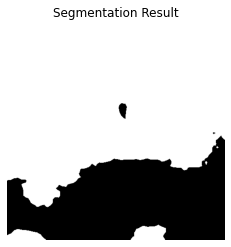

In [151]:
# 2개 클래스 (road=0, none_road=1) → 흑백 팔레트 사용
palette = np.array([[0, 0, 0],  # road (검은색)
                    [255, 255, 255]])  # none_road (흰색)

for i, (image, target) in enumerate(val_loader):
    image = image.to(args["device"])

    model.eval()  # ✅ 모델을 평가 모드로 설정

    with torch.no_grad():
        output = model(image)
        output = F.interpolate(output, size=image.shape[2:], mode="bilinear", align_corners=False)  # ✅ 원본 크기로 리사이즈
        output = output.argmax(dim=1).cpu().numpy()

out = output[0]  # 첫 번째 배치의 결과 가져오기
out = np.squeeze(out)  # 불필요한 차원 제거

# ✅ 컬러 팔레트 적용 (각 클래스에 해당하는 색상을 매핑)
pred = palette[out]  

print(out.shape)  # 출력 크기 확인

# 시각화
plt.imshow(pred)
plt.title("Segmentation Result")
plt.axis("off")
plt.show()

In [152]:
# 클래스 19개
out = outputs[0][0]
# 입력 이미지 리사이즈 후 inference
# im = F.interpolate(im, size=new_size, align_corners=False, mode='bilinear')
# out = net(im) # out = net(im)[0] <- 마지막 인덱싱은 없어도 된다.
# shape divisor

# org_size = im.size()[2:]
# new_size = [math.ceil(el / 32) * 32 for el in im.size()[2:]]

# out = F.interpolate(out, size=org_size, align_corners=False, mode='bilinear')
print(out.shape)
out = out.argmax(dim=1)
print(out.shape)

# visualize
out = out.squeeze().detach().cpu().numpy()
pred = palette[out] # 앞서 컬러 팔레트는 랜덤으로 세팅


torch.Size([1024, 2048])
torch.Size([1024])


IndexError: index 1894 is out of bounds for axis 0 with size 2

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(pred)  # 세그멘테이션 결과 이미지 출력
plt.axis("off")  # 축 제거 (선택 사항)
plt.show()

In [92]:
# Cityscapes 19개 클래스 정의
CITYSCAPES_CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car",
    "truck", "bus", "train", "motorcycle", "bicycle"
]

# Cityscapes 클래스별 RGB 색상
CITYSCAPES_COLORS = {
    "road": (128, 64, 128), "sidewalk": (244, 35, 232), "building": (70, 70, 70),
    "wall": (102, 102, 156), "fence": (190, 153, 153), "pole": (153, 153, 153),
    "traffic light": (250, 170, 30), "traffic sign": (220, 220, 0), "vegetation": (107, 142, 35),
    "terrain": (152, 251, 152), "sky": (70, 130, 180), "person": (220, 20, 60),
    "rider": (255, 0, 0), "car": (0, 0, 142), "truck": (0, 0, 70), "bus": (0, 60, 100),
    "train": (0, 80, 100), "motorcycle": (0, 0, 230), "bicycle": (119, 11, 32)
}

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 예측된 결과를 정수 클래스 ID로 변환
out = outputs[0][0].argmax(dim=1).cpu().numpy()

# 예측된 클래스 ID 중 실제로 등장한 클래스 찾기
unique_class_ids = np.unique(out)  # 예측된 클래스 ID
detected_classes = [CITYSCAPES_CLASSES[i] for i in unique_class_ids]  # 클래스 이름 매칭

# 클래스 ID를 색상 팔레트로 변환
pred = np.zeros((*out.shape, 3), dtype=np.uint8)  # RGB 이미지 형태 생성
for class_id in unique_class_ids:
    pred[out == class_id] = CITYSCAPES_COLORS[CITYSCAPES_CLASSES[class_id]]

# 불필요한 차원 제거 (Matplotlib이 올바르게 인식하도록)
pred = np.squeeze(pred)  # (1, H, W, 3) → (H, W, 3)으로 변경

# 시각화 (클래스별 색상 범례 추가)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 클래스 범례 출력
axes[0].imshow(pred)  # 수정된 `pred`를 사용
axes[0].set_title("Segmentation Result")
axes[0].axis("off")

# 클래스별 색상 범례 추가
patches = [mpatches.Patch(color=np.array(CITYSCAPES_COLORS[class_name]) / 255.0, label=class_name)
           for class_name in detected_classes]
axes[1].legend(handles=patches, loc="center", fontsize="small", title="Classes")
axes[1].axis("off")

plt.tight_layout()
plt.show()

NameError: name 'outputs' is not defined

---

# miou 확인하기

In [94]:
# 기본 라이브러리
import os
import torch
import torch.utils.data as data
from data_loader import get_segmentation_dataset  # 데이터셋 로드 함수
from utils.metric import SegmentationMetric  # 평가 지표

In [95]:
# 설정 (Jupyter Notebook 환경에 맞게 변경)
args = {
    "dataset": "citys",  # 사용할 데이터셋 (Cityscapes)
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # GPU/CPU 설정
    "batch_size": 1,  # 평가 시 배치 크기
    "num_workers": 0,  # DataLoader의 worker 개수 (메모리 문제 방지 위해 0으로 설정)
    "weight_path": "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/model_19_2.pth"  # 저장된 가중치 경로
}

In [96]:
# 가중치 파일 확인
if not os.path.exists(args["weight_path"]):
    raise FileNotFoundError(f"가중치 파일이 존재하지 않습니다: {args['weight_path']}")

# 이미지 전처리 설정
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

In [97]:
# 검증 데이터셋 로드 (Cityscapes val set)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="testval", transform=input_transform)
val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=args["batch_size"],
    shuffle=False,
    num_workers=args["num_workers"]
)

# 모델 및 가중치 로드
# model = BiSeNetv2(num_class=val_dataset.num_class).to(args["device"])  # 모델 생성

# 저장된 가중치 파일 로드
checkpoint = torch.load(args["weight_path"], map_location=args["device"])

# 가중치 파일에 state_dict가 포함되어 있으면, 모델 가중치만 추출하여 로드
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])  # state_dict만 로드
else:
    model.load_state_dict(checkpoint)  # 이미 순수한 가중치 파일이면 그대로 로드

model.eval()  # 모델을 평가 모드로 설정
print("모델 및 가중치 로드 완료!")

# 평가 지표 설정 (mIoU 및 픽셀 정확도)
metric = SegmentationMetric(val_dataset.num_class)

Found 500 images in /aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/val
모델 및 가중치 로드 완료!


In [98]:
# 검증 수행 및 mIoU 계산
print("검증 데이터셋 평가 중...")
with torch.no_grad():
    for i, (image, label) in enumerate(val_loader):
        image = image.to(args["device"])
        label = label.cpu().numpy().squeeze()  # GPU -> CPU 후 불필요한 차원 제거

        # 모델 예측 수행
        outputs = model(image)

        # 모델 출력이 (C, W)로 잘못 나오는 경우, 올바르게 변환
        if len(outputs.shape) == 3:  # (C, H, W) 형태라면 batch 차원이 없음 -> 추가
            outputs = outputs.unsqueeze(0)  # (1, C, H, W) 형태로 변환
        elif len(outputs.shape) == 2:  # (C, W) 형태라면 차원 재배열 필요
            outputs = outputs.view(1, outputs.shape[0], 1, outputs.shape[1])  # (1, C, 1, W)로 변환
        
        # 예측 결과 계산
        pred = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # (H, W) 형태로 변환
        
        # 평가 지표 업데이트
        metric.update(pred, label)

        # 10개마다 중간 결과 출력
        if (i + 1) % 10 == 0:
            pixAcc, mIoU = metric.get()
            print(f"Sample {i+1}: Pixel Accuracy = {pixAcc * 100:.2f}%, mIoU = {mIoU * 100:.2f}%")

# 최종 평가 결과 출력
final_pixAcc, final_mIoU = metric.get()
print("\n최종 평가 결과")
print(f"Pixel Accuracy: {final_pixAcc * 100:.2f}%")
print(f"Mean IoU (mIoU): {final_mIoU * 100:.2f}%")

검증 데이터셋 평가 중...
Sample 10: Pixel Accuracy = 12.65%, mIoU = 1.16%
Sample 20: Pixel Accuracy = 13.54%, mIoU = 1.36%
Sample 30: Pixel Accuracy = 13.35%, mIoU = 1.34%
Sample 40: Pixel Accuracy = 13.48%, mIoU = 1.39%
Sample 50: Pixel Accuracy = 13.48%, mIoU = 1.39%
Sample 60: Pixel Accuracy = 13.92%, mIoU = 1.43%
Sample 70: Pixel Accuracy = 14.07%, mIoU = 1.46%
Sample 80: Pixel Accuracy = 13.53%, mIoU = 1.41%
Sample 90: Pixel Accuracy = 14.07%, mIoU = 1.49%
Sample 100: Pixel Accuracy = 14.30%, mIoU = 1.53%
Sample 110: Pixel Accuracy = 14.33%, mIoU = 1.52%
Sample 120: Pixel Accuracy = 14.41%, mIoU = 1.53%
Sample 130: Pixel Accuracy = 14.12%, mIoU = 1.50%
Sample 140: Pixel Accuracy = 14.25%, mIoU = 1.50%
Sample 150: Pixel Accuracy = 14.40%, mIoU = 1.52%
Sample 160: Pixel Accuracy = 14.53%, mIoU = 1.53%
Sample 170: Pixel Accuracy = 14.16%, mIoU = 1.49%
Sample 180: Pixel Accuracy = 14.32%, mIoU = 1.50%
Sample 190: Pixel Accuracy = 14.47%, mIoU = 1.52%
Sample 200: Pixel Accuracy = 14.49%, mIoU =

## 가중치 파일에 담겨있는 정보 확인하기

In [ ]:
import torch

# 가중치 파일 경로
pth_file = "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth"

# 가중치 파일 로드
checkpoint = torch.load(pth_file, map_location="cpu")

# 가중치 파일에 저장된 key 목록 출력
print("가중치 파일에 포함된 키 목록:")
for key in checkpoint.keys():
    print(f"  - {key}")

# 모델 가중치가 저장된 키가 있는지 확인
if "state_dict" in checkpoint:
    print("\n'state_dict' 키가 포함됨 (모델 가중치 포함)")
    state_dict = checkpoint["state_dict"]

    # 가중치 레이어 이름 출력 (최대 10개만)
    print("\n가중치 레이어 목록:")
    for i, (name, param) in enumerate(state_dict.items()):
        if i < 10:  # 10개까지만 출력
            print(f"  - {name}: {param.shape}")
        else:
            print("  ... (더 많은 가중치가 있음)")
            break
else:
    print("\n'state_dict' 키가 없음 (모델 가중치가 저장되지 않은 파일일 수 있음)")

# 체크포인트 파일에 다른 정보(예: 학습률, 에포크 등)가 저장되어 있는지 확인
metadata_keys = [key for key in checkpoint.keys() if key != "state_dict"]
if metadata_keys:
    print("\n추가적인 메타데이터 포함:")
    for key in metadata_keys:
        print(f"  - {key}: {checkpoint[key]}")
else:
    print("\n추가적인 학습 메타데이터 없음 (가중치 정보만 포함됨)")